In [95]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd

import sklearn
import os
import duckdb
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Layer, Dropout, BatchNormalization, LeakyReLU, Lambda
from keras.losses import Loss, mse, MeanSquaredError
from keras.optimizers import Optimizer, Adam
from keras.metrics import Mean
from keras.utils import to_categorical, plot_model, load_img, img_to_array
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

from sklearn.dummy import DummyRegressor

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

np.random.seed(1234)
tf.random.set_seed(1234)

# Outline

- [**Data Preparation**](#data-preparation)
    - [**Handling Some Outliers**](#handling-some-outliers)

# Data Preparation

In [75]:
# Connect to DuckDB
conn = duckdb.connect(database=f"data/taxi_data.duckdb", read_only=False)

# Define a schema for the table for parquet file
conn.sql("""
CREATE OR REPLACE TABLE yellow_taxi_2023_full (
VendorID INTEGER,         
tpep_pickup_datetime TIMESTAMP,
tpep_dropoff_datetime TIMESTAMP,
passenger_count FLOAT,       
trip_distance FLOAT,       
RatecodeID FLOAT,       
store_and_fwd_flag TEXT,        
PULocationID INTEGER,         
DOLocationID INTEGER,         
payment_type INTEGER,         
fare_amount FLOAT,       
extra FLOAT,       
mta_tax FLOAT,       
tip_amount FLOAT,       
tolls_amount FLOAT,       
improvement_surcharge FLOAT,       
total_amount FLOAT,       
congestion_surcharge FLOAT,       
airport_fee FLOAT 
);
""")

# table for geographical coordinates
conn.sql(
""" 
CREATE OR REPLACE TABLE taxi_zone_lookup_coord AS
    SELECT 
        LocationID,
        latitude,	
        longitude,
    FROM read_csv_auto('data/external/taxi_zone_lookup_coordinates.csv')
"""
)

root_dir = "data/raw/yellow/2023"
# Insert data directly into a DuckDB table from `.parquet` files
for month in sorted(os.listdir(root_dir)):
    month_path = os.path.join(root_dir, month)
    if os.path.isdir(month_path):
        for file in os.listdir(month_path):
            # concatenates the directory path with file name
            file_path = os.path.join(month_path, file)
            if file.endswith(".parquet"):
                # Using DuckDB SQL to read `.parquet` directly into a table
                conn.sql(f"""
                    COPY yellow_taxi_2023_full 
                    FROM '{file_path}' (FORMAT 'PARQUET');
                """)


conn.sql(
"""
SELECT COUNT(*) AS yellow_taxi_2023_count
FROM yellow_taxi_2023_full
""")
    

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────────┐
│ yellow_taxi_2023_count │
│         int64          │
├────────────────────────┤
│               34933659 │
└────────────────────────┘

We can check see that the number of instances for each month is balanced and there is some outliers, probably inserted in the table by mistake that needs to be removed.

In [76]:
conn.sql(
"""
SELECT
    strftime('%Y-%m', tpep_pickup_datetime) AS month,
    COUNT(*) AS count
FROM yellow_taxi_2023_full
GROUP BY month
ORDER BY month
""")

┌─────────┬─────────┐
│  month  │  count  │
│ varchar │  int64  │
├─────────┼─────────┤
│ 2001-01 │       6 │
│ 2002-12 │       9 │
│ 2003-01 │       6 │
│ 2008-12 │      23 │
│ 2009-01 │      14 │
│ 2014-11 │       1 │
│ 2022-10 │      11 │
│ 2022-12 │      25 │
│ 2023-01 │ 3066726 │
│ 2023-02 │ 2914003 │
│ 2023-03 │ 3403660 │
│ 2023-04 │ 3288248 │
│ 2023-05 │ 3513664 │
│ 2023-06 │ 3307259 │
│ 2023-07 │ 2907093 │
│ 2023-08 │ 2824201 │
│ 2023-09 │ 2846741 │
│ 2023-10 │ 3522269 │
│ 2023-11 │ 3339697 │
│ 2023-12 │       3 │
├─────────┴─────────┤
│      20 rows      │
└───────────────────┘

To add the correct geographic coordinates for the `PULocationID` and `DOLocationID` we can use this dataset from [kaggle](https://www.kaggle.com/datasets/yzhoukaggle/zone-coordinates-of-nyc-yellow-taxi-trip-records?resource=download&select=taxi_zone_lookup_coordinates.csv) and make a inner join to return records that have matching values for the columns id `PULocationID` and `DOLocationID`.

In [77]:
conn.sql(
"""
CREATE OR REPLACE TABLE yellow_taxi_2023 AS
SELECT
    yt2023.tpep_pickup_datetime AS pickup_datetime,
    yt2023.tpep_dropoff_datetime AS dropoff_datetime,
    pickup_zone.latitude AS pickup_latitude,
    pickup_zone.longitude AS pickup_longitude,
    dropoff_zone.latitude AS dropoff_latitude,
    dropoff_zone.longitude AS dropoff_longitude
FROM 
    (SELECT 
        tpep_pickup_datetime,
        tpep_dropoff_datetime, 
        PULocationID,
        DOLocationID,
        strftime('%Y-%m', tpep_pickup_datetime) AS month
    FROM yellow_taxi_2023_full
    WHERE strftime('%Y', tpep_pickup_datetime) = '2023'
    ORDER BY RANDOM()
    LIMIT 1500000) AS yt2023
INNER JOIN 
    taxi_zone_lookup_coord AS pickup_zone
        ON pickup_zone.LocationID = yt2023.PULocationID
INNER JOIN 
    taxi_zone_lookup_coord AS dropoff_zone
        ON dropoff_zone.LocationID = yt2023.DOLocationID;
"""
)

# Save the result table as csv file
conn.sql(
"""
SELECT * 
FROM yellow_taxi_2023
""").df().to_csv('data/raw/yellow/taxi_2023_raw.csv', index=False)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [79]:
df_taxi= pd.read_csv('data/raw/yellow/taxi_2023_raw.csv')

df_taxi.dropna(inplace = True)

df_taxi['pickup_datetime'] = df_taxi['pickup_datetime'].str.slice(0, 16)
df_taxi['pickup_datetime'] = pd.to_datetime( df_taxi['pickup_datetime'], utc = True, format = '%Y-%m-%d %H:%M')

df_taxi['dropoff_datetime'] = df_taxi['dropoff_datetime'].str.slice(0, 16)
df_taxi['dropoff_datetime'] = pd.to_datetime( df_taxi['dropoff_datetime'], utc = True, format = '%Y-%m-%d %H:%M')


# Minutes in  a day : 0-1440
df_taxi['min_of_day'] = (60*df_taxi['pickup_datetime'].dt.hour + df_taxi['pickup_datetime'].dt.minute)
# Days in a week: 0-6, where 0 is Monday and 6 Sunday
df_taxi['day_of_week'] = df_taxi['pickup_datetime'].dt.dayofweek
# Days in a year: 1-365 (or 366)
df_taxi['day_of_year'] = df_taxi['pickup_datetime'].dt.dayofyear
# Time of the  trip
df_taxi['trip_duration'] = (df_taxi['dropoff_datetime']- df_taxi['pickup_datetime']).dt.seconds

# Remove datetime columns
df_taxi.drop('pickup_datetime', axis = 1, inplace = True)
df_taxi.drop('dropoff_datetime', axis = 1, inplace = True)


df_taxi.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,min_of_day,day_of_week,day_of_year,trip_duration
0,40.76380,-73.99180,40.763800,-73.991800,633,1,87,300
1,40.76380,-73.99180,40.736800,-73.984500,165,6,211,720
2,40.71626,-74.01258,40.707200,-74.002700,1117,6,246,240
3,40.71131,-74.01590,40.726500,-73.981500,762,5,28,1800
4,40.70800,-74.01100,40.714722,-73.989444,787,3,285,540


In [80]:
df_taxi.to_parquet("data/raw/yellow/taxi_2023_raw.parquet", index=False)

## Handling Spatial and Temporal Outliers

The boxplot for detecting outliers relies on the assumption that the data has a distribution close to normal (Gaussian), which is often not true with geospatial coordinates due to their unique patterns influenced by urban roads and traffic. Therefore, we will use a different approach to identify outliers in the location features.

For pickup and dropoff locations, the strategy is to use geospatial data using shapfile from NYC Borough Boundaries to identify points that fall outside the boundaries of NYC map as outliers.

In [103]:
df_taxi = pd.read_parquet('data/raw/yellow/taxi_2023_raw.parquet')

In [106]:
def plot_points_map(df, gdf_map, geometry_col, ax, title='', within_map=True, 
                    color_map='beige', color_points='black'):
    """
    Plots a map with points from a DataFrame onto a given Axes object.

    Parameters:
    - df: DataFrame with the coordinates to plot.
    - gdf_map: GeoDataFrame of the map boundaries.
    - geometry_col: GeoDataFrame column with geometry data.
    - ax: Matplotlib Axes object to plot on.
    - title: Title of the plot.
    - within_map: If True, only plots points within the map boundaries.
    - color_map: Color for the map.
    - color_points: Color for the points.
    """
    # convert to the same coordinate reference system
    gdf_points = gpd.GeoDataFrame(df, geometry=geometry_col)
    # convert to the same coordinate reference system
    gdf_points.crs = gdf_map.crs
    
    # If within_map is True, perform spatial join with the map boundaries
    # only points within the boundaries will be plotted
    if within_map:
        gdf_points = gpd.sjoin(gdf_points, gdf_map, how="inner", predicate='within')
        # Update the original DataFrame 
        df = df.loc[gdf_points.index]
        
    # Plot the map and the points
    gdf_map.plot(ax = ax, color=color_map, edgecolor='grey')
    gdf_points.plot(ax =ax, markersize=20, color = color_points, marker = 'x')
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.set_title(title, fontsize=20)

    return df

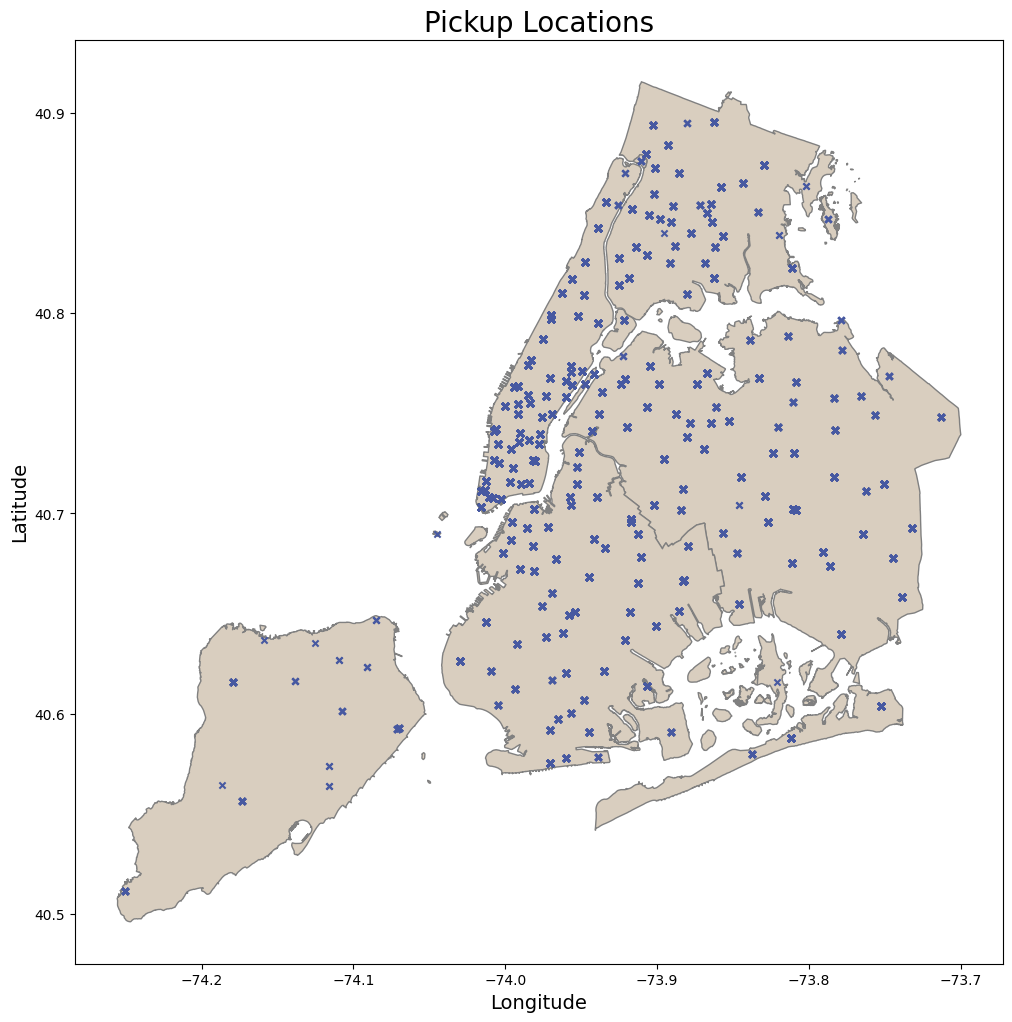

Number of outliers removed: 82690


In [107]:
nybb_path = 'data/external/nyc-borough-boundaries/geo_export_e13eede4-6de2-4ed8-98a0-58290fd6b0fa.shp'
nyc_boundary = gpd.read_file(nybb_path)

# Creating the geometry for points
geometry = gpd.points_from_xy(df_taxi['pickup_longitude'], df_taxi['pickup_latitude'])

# Creating the plot
fig, ax = plt.subplots(figsize=(12, 12))
pickup_within_nyc = plot_points_map(    df = df_taxi, gdf_map = nyc_boundary, 
                                        geometry_col = geometry, ax = ax, title =  'Pickup Locations',
                                        color_map= '#d9cebfff', color_points= '#4759A1'  ) 

# Showing the plot
plt.show()

print(f'Number of outliers removed: {len(df_taxi) - len(pickup_within_nyc)}')



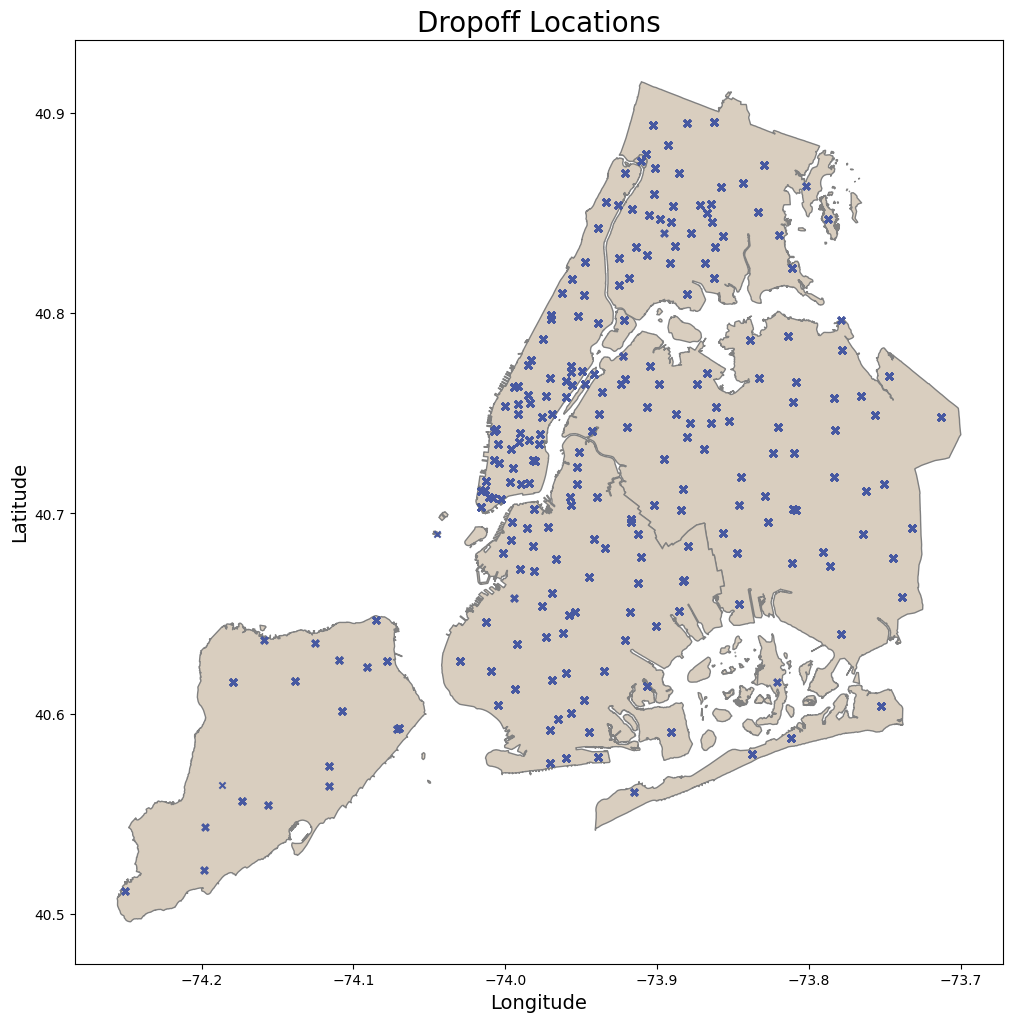

Number of outliers removed:78073


In [108]:
geometry = gpd.points_from_xy(pickup_within_nyc['dropoff_longitude'], 
                                pickup_within_nyc['dropoff_latitude'])

fig, ax = plt.subplots(figsize=(12, 12))
pickup_dropoff_within_nyc = plot_points_map(    df = pickup_within_nyc, gdf_map = nyc_boundary, 
                                                geometry_col = geometry, ax = ax, title =  'Dropoff Locations',
                                                color_map= '#d9cebfff', color_points= '#4759A1'  )
plt.show()




print(f'Number of outliers removed:{len(pickup_within_nyc) - len(pickup_dropoff_within_nyc)}' )

In [85]:
# update dataset with the removed outliers
df_taxi = pickup_dropoff_within_nyc.copy()
display(df_taxi.shape)

(1313874, 8)

In [86]:
def boxplot_stats(series, whis = 1.5):
    """
    Calculate the statistics for a box plot.

    Returns:
    dict: A dictionary containing the quartiles, IQR, and whisker limits.
    """
    Q1 = series.quantile(0.25)
    Q2 = series.quantile(0.50)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_whisker = Q1 - whis * IQR
    upper_whisker = Q3 + whis * IQR

    return {
        'Q1': Q1,
        'Q2': Q2,
        'Q3': Q3,
        'IQR': IQR,
        'lower_whis': lower_whisker,
        'upper_whis': upper_whisker
    }


def plot_distribution_boxplot(  series, ax1, ax2, title='', label='', log1p=True, 
                                draw_quartiles=True, kde=True):
    """
    Plot the distribution and boxplot of a series on given axes.

    Args:
    - series (pandas.Series): The series to plot.
    - ax1 (matplotlib.axes.Axes): The axes for the histogram.
    - ax2 (matplotlib.axes.Axes): The axes for the boxplot.
    - title (str): The title of the plot.
    - label (str): The label for the x-axis.
    - log1p (bool): If True, applies log1p transformation to the series.
    - draw_quartiles (bool): If True, draws quartile lines on the histogram.
    - kde (bool): If True, plots a KDE over the histogram.
    """
    if log1p:
        series = np.log1p(series)
    stats = boxplot_stats(series)

    sns.histplot(   series, bins=40, linewidth=0.5, color='#dfdc7bff', alpha=0.2,
                    ax=ax1, kde=kde, line_kws={'lw': 3})
    ax1.set_title(f'{title} Histogram', fontsize=15)
    ax1.set_xlabel(label, fontsize=14)
    ax1.set_ylabel('Count', fontsize=14)

    sns.boxplot(data=series, color='#dfdc7bff', ax=ax2,
                fliersize=3, flierprops={'color': '#50566dff', 'markeredgecolor': '#50566dff'})
    
    ax2.set_title(f'{title} Boxplot', fontsize=15)
    ax2.set_ylabel(label, fontsize=14)

    if draw_quartiles:
        quartiles = [stats['Q1'], stats['Q3'], stats['lower_whis'], stats['upper_whis']]
        for line in quartiles:
            ax1.axvline(line, color='#50566dff', linestyle='--', alpha=1, lw=2)
            y_center = ax1.get_ylim()[1] / 2
            ax1.text(   line, y_center, f'{line:.2f}',
                        fontsize=18, color='black', va='center', ha='right', rotation=90)



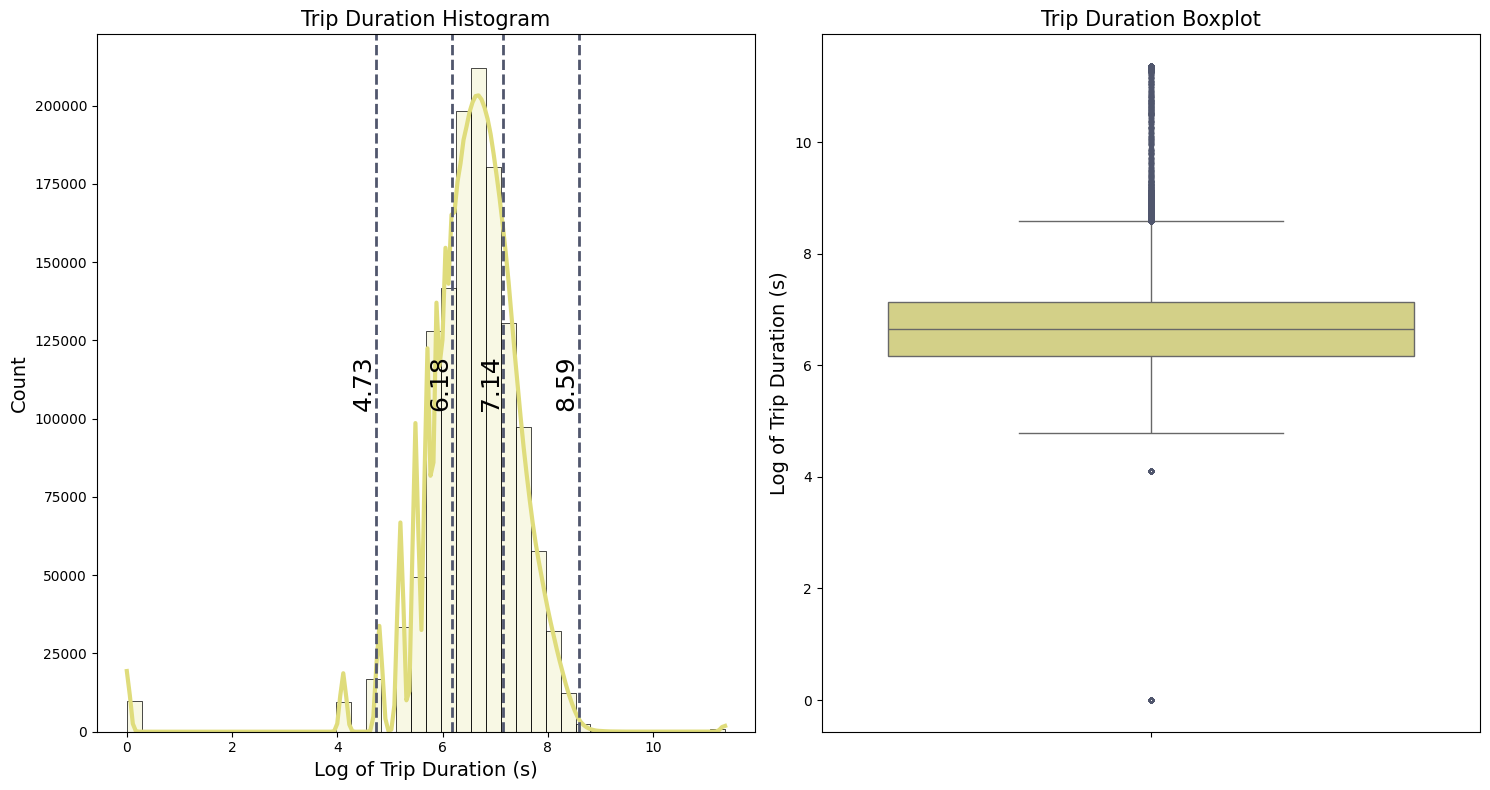

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
plot_distribution_boxplot(  df_taxi['trip_duration'], ax1, ax2,
                            title='Trip Duration', label='Log of Trip Duration (s)')

plt.tight_layout()
plt.show()

Because of the high values and zeros in the target feature `trip_duration`, we apply the logarithmic transformation $\log(x+1)$. This transformation reduces the effect of outliers and the overall variance in the dataset.The histogram, illustrated in the first plot, resembles a bell curve after applying this transformation. From the boxplot, we can see:

- The first and third quartiles ($Q_1$ and $Q_3$) representing the 25th and 75th percentiles, are:

  - $Q_1 = 6.18$
  - $Q_3 = 7.14$

- The interquartile range (IQR) is the difference between the third and first quartiles:
  - IQR = $Q_3 - Q_1 = 0.96$

- The whiskers indicate the range of the data:
  - The lower whisker :  $Q_1 - 1.5 IQR = 4.74$
  - The upper whisker :  $Q_3 + 1.5 IQR = 8.58$

Data points outside the whiskers are potential outliers that need further validation. For better intuition, we convert these whisker values from the log scale back to the original scale in terms of hours ($\text{Hours} = \text{Seconds}/3600$ ):

$$\frac{\exp(4.74) - 1}{3600} \approx  0.031 ~~\text{hours}$$
$$\frac{\exp(8.58) - 1}{3600} \approx  1.48 ~~\text{hours}$$

The lower whisker corresponds to approximately 1.4 minutes, which is very short for a taxi trip duration, suggesting that these could be errors or special cases.The upper whisker suggests a more plausible trip duration of about 1.32 hours, but with very unrealistic high values with more than 20 hours of duration. 

In [88]:
def count_outliers(series, whis = 1.5):
        """
        Count the number of upper and lower outliers in the series and print their percentages.

        Args:
        series (pd.Series): Series for which to count outliers.

        Returns:
        (pd.Series, pd.Series): Two boolean series, one for upper outliers and one for lower outliers.
        """

        stats = boxplot_stats(series, whis)


        upper_outliers = (series > stats['upper_whis'])
        lower_outliers = (series < stats['lower_whis'])

        # Percentage of outliers 
        percentage_upper = upper_outliers.sum() / len(series) * 100
        percentage_lower = lower_outliers.sum() / len(series) * 100

        print(  f'\nPotential upper outliers: {upper_outliers.sum()} '
                f'({percentage_upper:.2f}% of the dataset)')

        print(  f'\nPotential lower outliers: {lower_outliers.sum()} '
                f'({percentage_lower:.2f}% of the dataset)')

        return upper_outliers, lower_outliers


log_trip_duration = np.log1p(df_taxi['trip_duration'])
upper_duration_outliers, lower_duration_outliers = count_outliers(log_trip_duration)


Potential upper outliers: 3095 (0.24% of the dataset)

Potential lower outliers: 19049 (1.45% of the dataset)


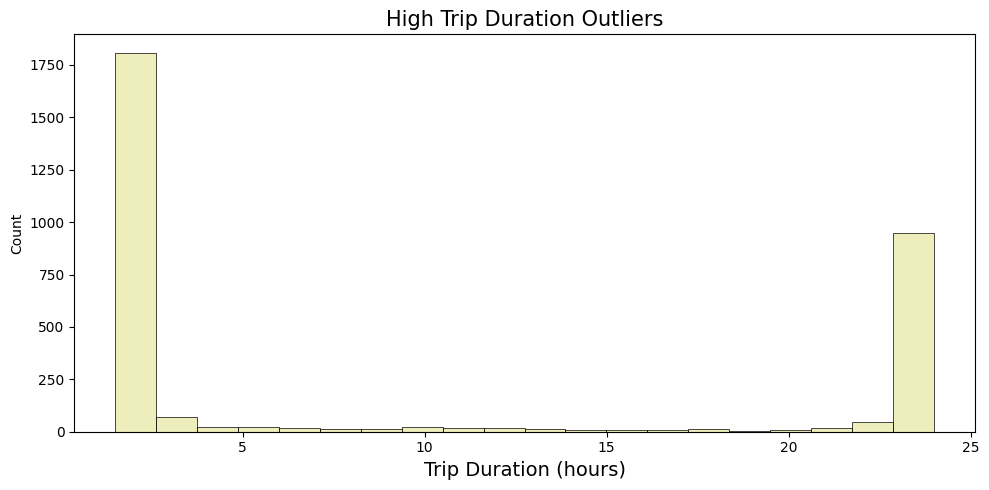

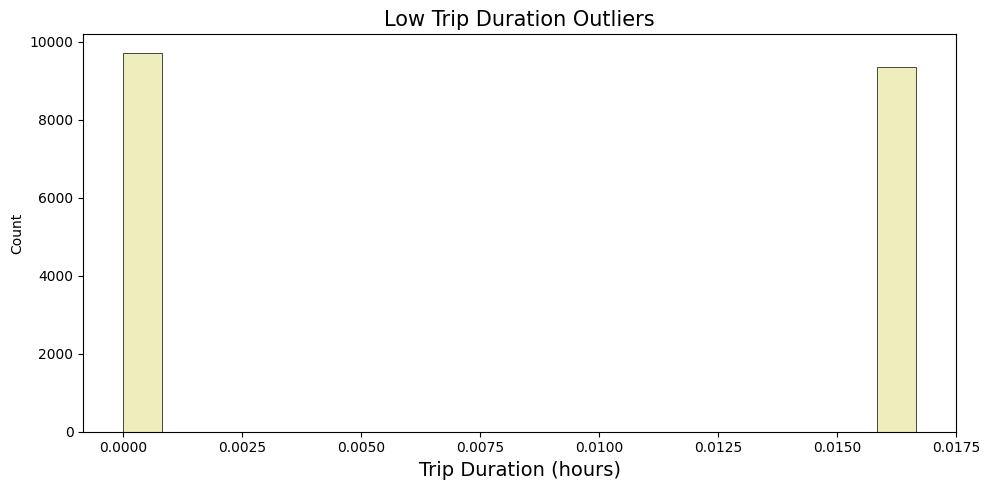

In [89]:
# bar plot for upper whisker
upper_outliers = df_taxi[upper_duration_outliers]['trip_duration'].reset_index(drop=True)/3600

fig, axes = plt.subplots(1, 1, figsize= (10, 5))
sns.histplot(  upper_outliers, bins=20, linewidth=0.5, color='#dfdc7bff', alpha=0.5)
axes.set_title(f'High Trip Duration Outliers', fontsize=15)
axes.set_xlabel('Trip Duration (hours)', fontsize=14)
plt.tight_layout()
plt.show()


# bar plot for lower whisker
lower_outliers = df_taxi[lower_duration_outliers]['trip_duration'].reset_index(drop=True)/3600

fig, axes = plt.subplots(1, 1, figsize= (10, 5))
sns.histplot(  lower_outliers, bins=20, linewidth=0.5, color='#dfdc7bff', alpha=0.5)
axes.set_title(f'Low Trip Duration Outliers', fontsize=15)
axes.set_xlabel('Trip Duration (hours)', fontsize=14)
plt.tight_layout()
plt.show()

In [90]:
# Select only trip duration above the lower whisker (above 1 minute 54 seconds)
df_taxi = df_taxi[~lower_duration_outliers].copy()

# Select only trip duration lower then 5 hours
df_taxi = df_taxi[df_taxi['trip_duration'] <= 5 * 3600].copy()

df_taxi.shape

(1293631, 8)

In [91]:
# Transform target column using log1p
df_taxi['trip_duration'] = np.log1p(df_taxi['trip_duration'])

# Normalize data for the BNN
df_taxi = (df_taxi - df_taxi.mean()) / df_taxi.std()

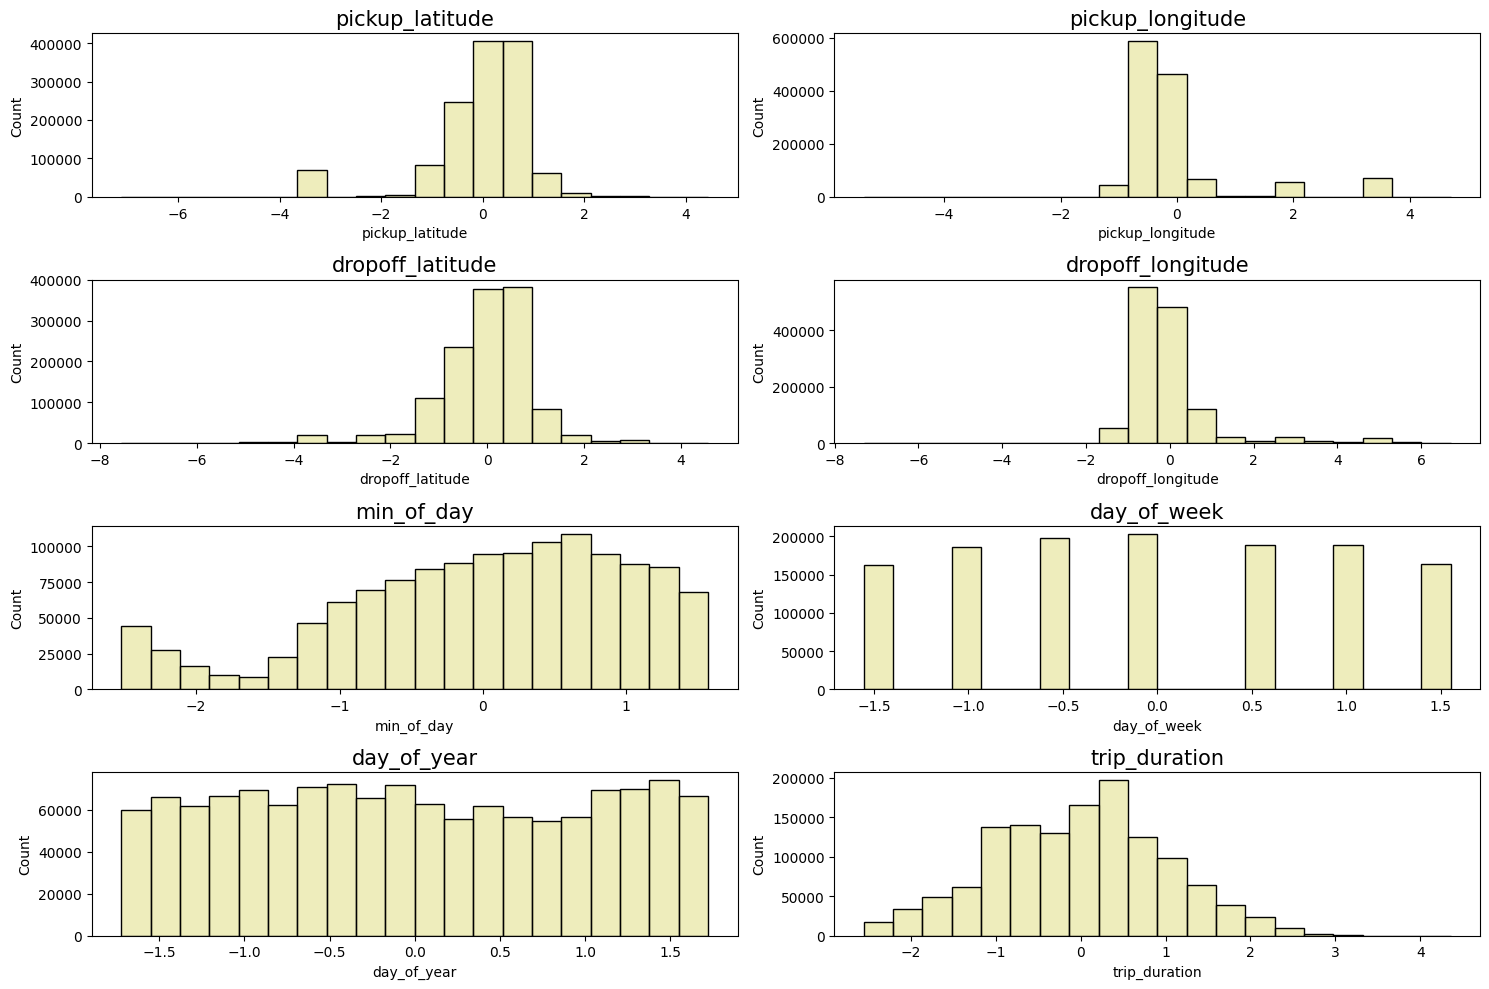

In [92]:
plt.figure(figsize=(15, 10))
for i in range(8):
    plt.subplot(4, 2, i+1)
    sns.histplot(df_taxi.iloc[:, i],bins=20, linewidth=1, color='#dfdc7bff', alpha=0.5)
    plt.title(df_taxi.columns[i], fontsize=15)
plt.tight_layout()
plt.show()

In [93]:
df_taxi.to_parquet("data/processed/yellow_taxi_2023.parquet", index=False)

# Base Line Models

In [ ]:
## Split dataset
#df_train_large, df_test = train_test_split(df_taxi, test_size = 0.2, random_state = 42)
#df_train, df_val = train_test_split(df_train_large, train_size = 0.75, random_state = 42)
#
## Save target feature
#Y_train_large = df_train_large['trip_duration'].values
#Y_test = df_test['trip_duration'].values
#Y_train = df_train['trip_duration'].values
#Y_val = df_val['trip_duration'].values
#
## Drop target feature 
#df_train.drop('trip_duration', axis=1, inplace=True)
#df_val.drop('trip_duration', axis=1, inplace=True)
#df_test.drop('trip_duration', axis=1, inplace=True)

In [102]:
# Split the dataframe into dependent abd independent columns
Y_trip = df_taxi['trip_duration'].copy()
X_trip = df_taxi.drop('trip_duration', axis=1)

# Baseline Models

# Make Mean Absolute Error scorer
#mae_scorer = make_scorer(mean_absolute_error)

# Create the rmse scorer
rmse_scorer = make_scorer(mean_squared_error)

# Function to print cross-validated mean abs deviation
def cv_mae(regressor, x, y, cv=3, scorer=rmse_scorer):
    scores = cross_val_score(regressor, 
                             x, y, cv=cv,
                             scoring=scorer)
    print('rmse:', scores)

cv_mae(DummyRegressor(), Y_trip, X_trip)

rmse: [0.66172932 0.66080487 1.89010179]


# Bayesian Neural Network

In [ ]:
class DenseVariational(Layer):
    def __init__(self, units, activation=None, kl_weight=1e-3, name = 'DenseVariational'):
        
        """
        Initializes the custom variational dense layer.

        Args:
            units (int): The number of neurons in the dense layer.
            activation (str or callable, optional): The activation function to use on the layer's output. 
                Defaults to None, which means no activation is applied.
            kl_weight (float, optional): Weight factor for the Kullback-Leibler divergence term in the loss function. 
                Defaults to 1e-3.
            name (str): The name of the layer.
        """
              
        super(DenseVariational, self).__init__(name = name)

        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.kl_weight = kl_weight

    def xavier(self, shape):

        """
        Performs Xavier initialization for the layer's weights and biases.

        Args:
            shape (tuple): The shape of the tensor to initialize.

        Returns:
            tf.Tensor: A tensor with the specified shape initialized using the Xavier initialization method.
        """
        xavier_dist = tf.random.truncated_normal (shape=shape, mean=0.0, stddev=np.sqrt(2.0 / sum(shape)))

        return xavier_dist

    def build(self, input_shape):

        """
        Builds the variational dense layer by initializing weights and biases with their respective means and standard deviations.

        Args:
            input_shape (tuple): The shape of the input to the layer, used to determine the weight shapes.
        """

        d_in = input_shape[-1]
        # Initializing mean and standard deviation for weights and biases to represent their posterior distributions.
        self.w_mean = tf.Variable(self.xavier((d_in, self.units)), name='w_mean')
        self.w_std = tf.Variable(self.xavier((d_in, self.units)) - 6, name='w_std')
        self.b_mean = tf.Variable(self.xavier((self.units,)), name='b_mean')
        self.b_std = tf.Variable(self.xavier((self.units,)) - 6, name='b_std')

    def call(self, x, training = True):

        """
        Perform the forward pass through the layer, either stochastically, if in training mode, or deterministically.
        Variational Inference: Stochastic forward pass involves sampling from approximate posterior distributions.
        """

        if training: # Stochastic forward pass (sampling process)
            
            # Softplus to ensure std is positive
            w_std = tf.nn.softplus(self.w_std)
            b_std = tf.nn.softplus(self.b_std)
            
            # Random noise for sampling from Gaussian distributions
            # Correlation problem: Unique perturbations for each df_taxi point
            # Consider implementing the Flipout estimator to address correlation issues in gradients
            w_noise = tf.random.normal(shape=self.w_mean.shape)
            b_noise = tf.random.normal(shape=self.b_mean.shape)
            
            # Samples from the posterior distributions for weights and biases
            w_sample = self.w_mean + w_std*w_noise
            b_sample = self.b_mean + b_std*b_noise
            output = x @ w_sample + b_sample

        else: # Deterministic forward pass
            output =  x @ self.w_mean + self.b_mean
        
        if self.activation is not None:
            output = self.activation(output)
            
        return output

    @property
    def loss(self):

        """
        Computes the regularization loss for this layer, quantified as the Kullback-Leibler (KL) divergence 
        between the approximate posterior and the prior distributions of the layer's weights and biases. 
        This loss term encourages the weights to remain close to the prior, preventing overfitting and 
        ensuring that the learned representations are robust.

        The KL divergence is scaled by the kl_weight, which balances the influence of this regularization 
        term against other components of the overall loss function.

        Returns:
            tf.Tensor: The computed regularization loss for this layer, as a scalar tensor.
        """

        # Prior distribution 
        prior = tfd.Normal(loc=0, scale=1)

        # Posterior distributions
        # Softplus to ensure std is positive
        weight_posterior = tfd.Normal(loc=self.w_mean, scale=tf.nn.softplus(self.w_std))
        bias_posterior = tfd.Normal(loc=self.b_mean, scale=tf.nn.softplus(self.b_std))

        # Kullback-Leibler divergence between posterior and prior distributions
        kl_w = tf.reduce_sum(tfd.kl_divergence(weight_posterior, prior))
        kl_b = tf.reduce_sum(tfd.kl_divergence(bias_posterior, prior))
        
        # Total loss of the layer
        kl_loss = self.kl_weight * (kl_w + kl_b)
        return kl_loss

In [ ]:
class BayesianNN(Model):
    def __init__(self,
                 layer_units: list = [5, 5],
                 output_unit: int = 1,
                 activation_func: str = 'relu',
                 output_activation: str = None, 
                 kl_weight: float = 1e-3,
                 name = "BayesianNN"):
        
        """
        Initializes a Bayesian Neural Network with variational dense layers.

        Args:
            layer_units (list): A list of integers representing the number of units in each hidden layer.
            output_unit (int): The number of units in the output layer.
            activation_func (str): The activation function to use for all hidden layers.
            kl_weight (float): The weight factor for the Kullback-Leibler divergence term in the loss function.
            name (str): The name of the model.
        """

        super(BayesianNN, self).__init__(name=name)

        self.layer_units = layer_units
        self.output_unit = output_unit
        self.activation_func = activation_func
        self.kl_weight = kl_weight

        self.layer_list = []
        for i in range(len(layer_units)):
            self.layer_list += [ DenseVariational( units=layer_units[i],
                                               kl_weight=self.kl_weight, 
                                               activation=activation_func,
                                               name='DenseVariational_{}'.format(i)
                                               )]
            
        self.layer_list += [ DenseVariational(  units = self.output_unit,
                                            kl_weight = self.kl_weight,
                                            activation = output_activation,
                                            name = 'OutputLayer'
                                            )]
    
    def call(self, x):
        """
        Executes a forward pass through the network.

        Args:
            x (Tensor): The input tensor.

        Returns:
            Tensor: The output of the network after passing through all the layers.
        """
        for layer in self.layer_list:
            x = layer(x)
        return x
    
    @property
    def losses(self):
        """
        Aggregates the KL divergence losses from all layers into a single loss term.

        Returns:
            Tensor: The sum of the KL divergence losses from all layers.
        """
        # Summing up the KL divergence losses from all variational layers
        return tf.reduce_sum([layer.loss for layer in self.layer_list]) 

In [ ]:
class BayesianNN2Heads(Model):
    """
    Multilayer fully-connected Bayesian neural network, with two heads to predict
    both the mean and the standard deviation of the output distribution.

    Parameters
    ----------
    units : List[int]
        Number of output dimensions for each layer in the core network.
    head_units : List[int]
        Number of output dimensions for each layer in the head networks.
    name : None or str
        Name for the layer.
    """

    def __init__(self, core_units, heads_units, name = None):
        # Initialize the parent class
        super(BayesianNN2Heads, self).__init__(name = name)



        self.total_kl_tracker = Mean(name = 'total-kl')
        self.core_kl_loss_tracker = Mean(name = 'core-kl')
        self.loc_kl_loss_tracker = Mean(name = 'loc-kl')
        self.scale_kl_loss_tracker = Mean(name = 'scale-kl')
        self.elbo_tracker = Mean(name = 'elbo')


        # Create the core network using BayesianNN
        self.core_net = BayesianNN( layer_units = core_units[:-1], 
                                    output_unit = core_units[-1], 
                                    activation_func = 'relu',
                                    kl_weight = 1e-3) 
        
        # Create the location (mean) head network
        self.loc_net = BayesianNN(  layer_units = [core_units[-1]] + heads_units, 
                                    output_unit = 1,
                                    output_activation = 'relu',  
                                    activation_func = None,  
                                    kl_weight = 1e-3)    

        # Create the scale (standard deviation) head network
        self.scale_net = BayesianNN(  layer_units = [core_units[-1]] + heads_units, 
                                    output_unit = 1,  
                                    activation_func = 'relu', 
                                    output_activation =  'softplus',
                                    kl_weight = 1e-3)  
    
    def call(self, x, training = True):

        """
        Executes a forward pass through the network.

        Args:
            x (Tensor): The input tensor.

        Returns:
            Tensor: The output of the network after passing through all the layers.
        """
        # Pass the input through the core network
        x = self.core_net(x,  training = training)

        # Pass the output of the core network through the location and scale heads
        x_loc = self.loc_net(x,  training = training)
        x_scale = self.scale_net(x,  training = training)

        # Return the output of the location and scale heads
        return tf.concat([x_loc, x_scale], 1)
    

    def train_step(self, df_taxi):
        return self._process_step(df_taxi)
    
    @tf.function
    def tf_evaluate(self, x,  y):
        N = tf.shape(x)[0]
        with tf.GradientTape() as tape:

            log_likelihoods  = self.log_likelihood(x, y)
            # List of losses
            total_kl_loss, core_kl_loss, loc_kl_loss, scale_kl_loss = self.losses
            elbo_loss = total_kl_loss/float(N)  - tf.reduce_mean(log_likelihoods)

        grads = tape.gradient(elbo_loss, self.trainable_weights)  
        return total_kl_loss, core_kl_loss, loc_kl_loss, scale_kl_loss, elbo_loss, grads


    def _process_step(self, df_taxi):
        x, y = df_taxi
        total_kl_loss, core_kl_loss, loc_kl_loss,\
              scale_kl_loss, elbo_loss, grads = self.tf_evaluate(x, y)
        
        if self.optimizer != None:
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_kl_tracker(total_kl_loss)
        self.core_kl_loss_tracker(core_kl_loss) 
        self.loc_kl_loss_tracker(loc_kl_loss) 
        self.scale_kl_loss_tracker(scale_kl_loss) 
        self.elbo_tracker(elbo_loss) 

        dict_losses = {"total-kl":self.total_kl_tracker.result(),
                        "core-kl":self.core_kl_loss_tracker.result(),
                        "loc-kl":self.loc_kl_loss_tracker.result(),
                        "scale-kl":self.scale_kl_loss_tracker.result(),
                        "elbo":self.elbo_tracker.result() }
        
        return dict_losses
                            
    def log_likelihood(self, x, y, training = True):
        
        preds = self.call(x, training = training)
        loc, scale = preds[:, 0], preds[:, 1]
        
        # Return log likelihood of true df_taxi given predictions
        return  tfd.Normal(loc, scale).log_prob(y[:,0])
    
    @tf.function
    def sample(self, x):
        preds = self.call(x)
        loc, scale = preds[:, 0], preds[:, 1]
        return tfp.distributions.Normal(loc, scale).sample()
    
    def samples(self, x, n_sample = 1):
        N = x.shape[0]
        samples = np.zeros((N, n_sample))

        for i in range(n_sample):
           samples[:,i] = self.sample(x)
        return samples
    
    @property
    def losses(self):
        # KL-loss from the network
        core_kl_loss = self.core_net.losses
        loc_kl_loss = self.loc_net.losses
        scale_kl_loss = self.scale_net.losses
        total_kl_loss = core_kl_loss + loc_kl_loss + scale_kl_loss


        # KL-loss from the standard deviation based on df_taxi
        #posterior = tfp.distributions.Gamma(self.std_alpha, self.std_beta)
        #prior  = tfp.distributions.Gamma(10.0, 10.0)  #prior is fixed 
        #std_kl_loss = tfp.distributions.kl_divergence(posterior, prior)

        # Total loss
        #total_kl_loss = bnn2head_kl_loss #+ std_kl_loss

        return [total_kl_loss, core_kl_loss, loc_kl_loss, scale_kl_loss]#, bnn2head_kl_loss]
    

# Main

In [ ]:
X_train = df_train.to_numpy('float32', True)
Y_train = Y_train[:,None] 

In [ ]:
model = BayesianNN2Heads([7, 256, 128], [64, 32])
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4))
history = model.fit(X_train, Y_train, epochs = 100, batch_size= 32 )


Epoch 1/100
1135/1135 [==============================] - 8s 4ms/step - total-kl: 483.5251 - core-kl: 190.6365 - loc-kl: 146.3985 - scale-kl: 146.4901 - elbo: 16.5568
Epoch 2/100
1135/1135 [==============================] - 4s 3ms/step - total-kl: 473.5511 - core-kl: 186.7112 - loc-kl: 143.3218 - scale-kl: 143.5184 - elbo: 16.2305
Epoch 3/100
1135/1135 [==============================] - 4s 3ms/step - total-kl: 463.6307 - core-kl: 182.7930 - loc-kl: 140.2785 - scale-kl: 140.5592 - elbo: 15.9199
Epoch 4/100
1135/1135 [==============================] - 4s 3ms/step - total-kl: 453.7227 - core-kl: 178.8808 - loc-kl: 137.2398 - scale-kl: 137.6017 - elbo: 15.6094
Epoch 5/100
1135/1135 [==============================] - 4s 4ms/step - total-kl: 443.8265 - core-kl: 174.9753 - loc-kl: 134.2023 - scale-kl: 134.6487 - elbo: 15.3001
Epoch 6/100
1135/1135 [==============================] - 5s 4ms/step - total-kl: 433.9472 - core-kl: 171.0790 - loc-kl: 131.1656 - scale-kl: 131.7025 - elbo: 14.9903
Epoc

In [ ]:
history.history.keys()

dict_keys(['total-kl', 'core-kl', 'loc-kl', 'scale-kl', 'elbo'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


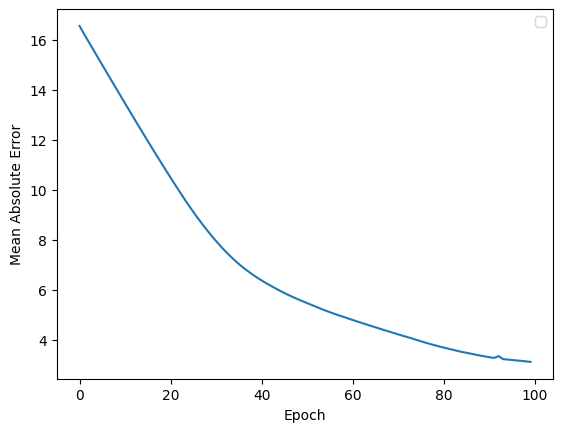

In [ ]:
plt.plot(history.history['elbo'])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.show()